In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re
# from keras_nlp.models import DistilBertTokenizer


/opt/anaconda3/envs/proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training = pd.read_csv("train.csv")
testing = pd.read_csv("test.csv")

In [3]:
training.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [4]:
testing.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**EXPLORATORY DATA ANALYSIS**

<Axes: ylabel='target'>

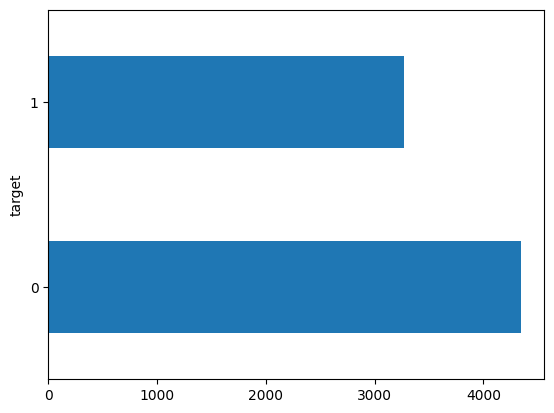

In [5]:
training['target'].value_counts().plot(kind = 'barh')

In [6]:
training['word_count'] = training['text'].apply(lambda x : len(x.split()))
testing['word_count'] = testing['text'].apply(lambda x : len(x.split()))

<Axes: title={'center': 'word_count'}, xlabel='target'>

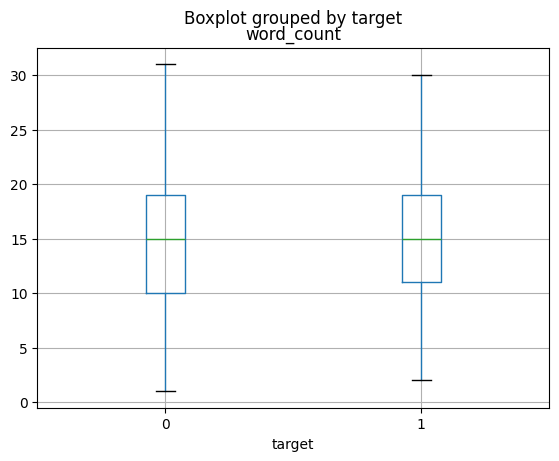

In [7]:
training.boxplot('word_count', by = 'target')

<Axes: >

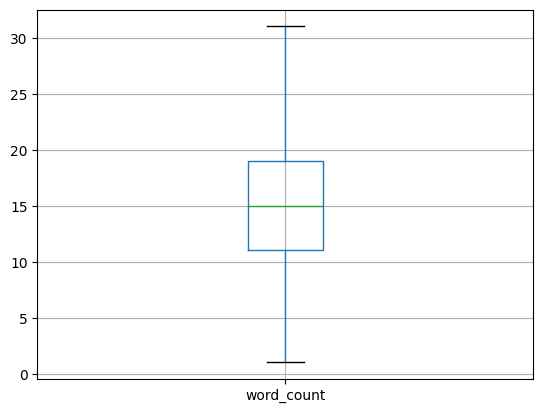

In [8]:
testing.boxplot('word_count')

**DATA PREPROCESSING**

In [9]:
training = training[['id', 'text', 'target']]
testing = testing[['id', 'text']]

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^a-zA-Z\s\.\,\!\?\']', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
training['clean_text'] = training['text'].apply(clean_text).tolist()
testing['clean_text'] = testing['text'].apply(clean_text)

In [12]:
training.head()

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,"13,000 people receive #wildfires evacuation or...",1,", people receive wildfires evacuation orders i..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [13]:
testing.head()

,id,text,clean_text
0,0,Just happened a terrible car crash,just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s...","heard about earthquake is different cities, st..."
2,3,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan


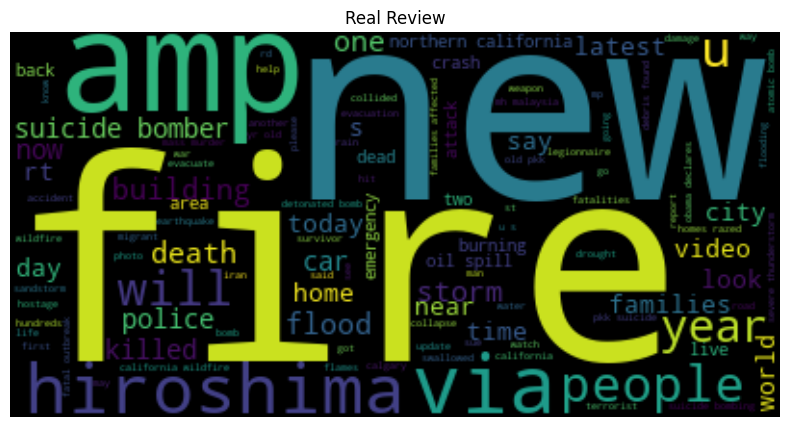

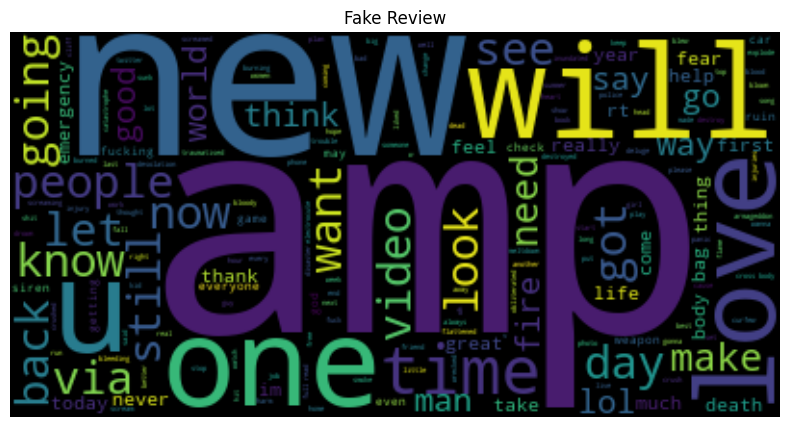

In [24]:
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=400, 
						height=200,
						stopwords=set(STOPWORDS), 
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


positive = training[training['target']==1]['clean_text'].tolist()
generate_wordcloud(positive,'Real Review')

negative = training[training['target'] == 0]['clean_text'].tolist()
generate_wordcloud(negative, 'Fake Review')

In [15]:
X = training['clean_text']
y = training['target']

**MODEL 1**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len = 64

In [18]:
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(), padding=True, truncation=True, max_length = max_len, return_tensors='tf')

In [19]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=16,
    epochs=3,
    callbacks=[early_stopping]
)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 35/267 [==>...........................] - ETA: 6:57 - loss: 0.6376 - accuracy: 0.6589

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

72/72 [==============================] - 79s 1s/step - loss: 0.4233 - accuracy: 0.8227
Test loss: 0.4232746958732605, Test accuracy: 0.8226795196533203


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

outputs = model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
logits = outputs.logits

predictions = tf.argmax(logits, axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Accuracy:", accuracy_score(y_test, predictions))

print("Classification Report:")
print(classification_report(y_test, predictions))

72/72 [==============================] - 69s 906ms/step
Confusion Matrix:
[[1115  211]
 [ 194  764]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1326
           1       0.78      0.80      0.79       958

    accuracy                           0.82      2284
   macro avg       0.82      0.82      0.82      2284
weighted avg       0.82      0.82      0.82      2284



**MODEL 2**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X.shape

(7613,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [ ]:
y_pred = model.predict(X_test_tfidf)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8108995403808273
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       874
           1       0.84      0.68      0.76       649

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

